In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.utils.data.sampler as sampler

import os
import fnmatch
import numpy as np
import random
import matplotlib.pyplot as plt

In [71]:
!nvidia-smi

Sun Nov 10 14:05:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [72]:
class CityScapes(Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = os.path.join(root, 'train')
        else:
            self.data_path = os.path.join(root, 'val')

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(os.path.join(self.data_path, 'image')), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'image', '{:d}.npy'.format(index))), -1, 0))
        semantic = torch.from_numpy(np.load(os.path.join(self.data_path, 'label', '{:d}.npy'.format(index))))
        depth = torch.from_numpy(np.moveaxis(np.load(os.path.join(self.data_path, 'depth', '{:d}.npy'.format(index))), -1, 0))
        
        return {'image': image.float(), 'semantic': semantic.float(), 'depth': depth.float()}

    def __len__(self):
        return self.data_len


In [36]:
cd working

/kaggle/working


In [73]:
dataset_path = '../input/data'
train_set = CityScapes(root=dataset_path, train=True)
test_set = CityScapes(root=dataset_path, train=False)

torch.Size([3, 108, 256]) torch.Size([103, 256]) torch.Size([1, 108, 256])


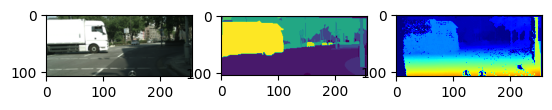

In [74]:
img_dict = test_set.__getitem__(21)
img = img_dict['image'][:, :-20]
sem = img_dict['semantic'][:-25, :]
depth = img_dict['depth'][:, :-20]
print(img.shape, sem.shape, depth.shape)

plt.subplot(1,3,1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1,3,2)
plt.imshow(sem)
plt.subplot(1,3,3)
plt.imshow(depth.permute(1, 2, 0), cmap='jet')

In [75]:
from torch . utils . data import DataLoader
batch_size = 8
train_loader = DataLoader ( train_set , batch_size = batch_size , shuffle = True )
test_loader = DataLoader ( test_set , batch_size = batch_size , shuffle = False )

In [76]:
# for i, batch in tqdm(enumerate(train_loader)):
#     print(batch['depth'].shape,batch['semantic'].shape )

In [77]:
def compute_loss(x_pred, x_output, task_type):
    device = x_pred.device

    # binary mark to mask out undefined pixel space
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(device)

    if task_type == 'semantic':
        # semantic loss : depth - wise cross entropy
        loss = F.nll_loss(x_pred, x_output, ignore_index=-1)

    if task_type == 'depth':
        # depth loss : l1 norm
        loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(
            binary_mask, as_tuple=False).size(0)

    return loss
xx = torch.rand(4,13,128,256)
yy = torch.rand(4,128,256).long()
print(compute_loss(xx,yy,'semantic'))

tensor(-0.4996)


In [78]:
import torch.nn as nn

class GLPDepthWithSegmentation(nn.Module):
    def __init__(self):
        super(GLPDepthWithSegmentation, self).__init__()
        # initialise network parameters

        filter = [64, 128, 256, 512, 512]

        self.class_nb = 21

        # define encoder decoder layers
        self.ViT_encoder_block = nn.ModuleList([self.conv_layer([3, filter[0]])])
        self.decoder_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            self.ViT_encoder_block.append(self.conv_layer([filter[i], filter[i + 1]]))
            self.decoder_block.append(self.conv_layer([filter[i + 1], filter[i]]))

        # define convolution layer
        self.tranformer_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        self.mlp = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            if i == 0:
                self.tranformer_block.append(self.conv_layer([filter[i + 1], filter[i + 1]]))
                self.mlp.append(self.conv_layer([filter[i], filter[i]]))
            else:
                self.tranformer_block.append(nn.Sequential(self.conv_layer([filter[i + 1], filter[i + 1]]),
                                                          self.conv_layer([filter[i + 1], filter[i + 1]])))
                self.mlp.append(nn.Sequential(self.conv_layer([filter[i], filter[i]]),
                                                          self.conv_layer([filter[i], filter[i]])))

        # define task specific layers
        self.SegFormerDecoder = nn.Sequential(nn.Conv2d(in_channels=filter[0], out_channels=filter[0], kernel_size=3, padding=1),
                                         nn.Conv2d(in_channels=filter[0], out_channels=self.class_nb, kernel_size=1, padding=0))
        self.GLPDepthDecoder = nn.Sequential(nn.Conv2d(in_channels=filter[0], out_channels=filter[0], kernel_size=3, padding=1),
                                         nn.Conv2d(in_channels=filter[0], out_channels=1, kernel_size=1, padding=0))

        # define pooling and unpooling functions
        self.down_sampling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.up_sampling = nn.MaxUnpool2d(kernel_size=2, stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    # define convolutional block
    def conv_layer(self, channel):
        conv_block = nn.Sequential(
            nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=channel[1]),
            nn.GELU()
        )
        return conv_block

    def forward(self, x):
        g_encoder, g_decoder, g_maxpool, g_upsampl, indices = ([0] * 5 for _ in range(5))
        for i in range(5):
            g_encoder[i], g_decoder[-i - 1] = ([0] * 2 for _ in range(2))

        # global shared encoder - decoder network
        for i in range(5):
            if i == 0:
                g_encoder[i][0] = self.ViT_encoder_block[i](x)
                g_encoder[i][1] = self.tranformer_block[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])
            else:
                g_encoder[i][0] = self.ViT_encoder_block[i](g_maxpool[i - 1])
                g_encoder[i][1] = self.tranformer_block[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])

        for i in range(5):
            if i == 0:
                g_upsampl[i] = self.up_sampling(g_maxpool[-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.mlp[-i - 1](g_decoder[i][0])
            else:
                g_upsampl[i] = self.up_sampling(g_decoder[i - 1][-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.mlp[-i - 1](g_decoder[i][0])

        # define task prediction layers
        pred_seg = F.log_softmax(self.SegFormerDecoder(g_decoder[i][1]), dim=1)
        pred_d = self.GLPDepthDecoder(g_decoder[i][1])

        return {'semantic': pred_seg, 'depth': pred_d}


In [80]:
from tqdm import tqdm

def train_epoch(train_loader, model, device, optimizer):
    # iteration for all batches
    model.train()
    losses = {'semantic': [], 'depth': [], 'total': []}
    for i, batch in tqdm(enumerate(train_loader)):
        images = batch['image'].to(device)
        semantic = batch['semantic'].long().to(device)
        depth = batch['depth'].to(device)
        output = model(images)


        optimizer.zero_grad()
        train_loss = {
            'semantic': compute_loss(output['semantic'], semantic, 'semantic'),
            'depth': compute_loss(output['depth'], depth, 'depth')
        }

        loss = train_loss['semantic'] + train_loss['depth']

        loss.backward()
        optimizer.step()

        losses['semantic'].append(train_loss['semantic'].item())
        losses['depth'].append(train_loss['depth'].item())
        losses['total'].append(loss.item())

    avg_losses = {task: sum(task_loss) / len(task_loss) for task, task_loss in losses.items()}
    print(1)
    return avg_losses

def evaluation_epoch(val_loader, model, device):
    # iteration for all batches
    model.eval()
    losses = {'semantic': [], 'depth': [], 'total': []}
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_loader)):
            images = batch['image'].to(device)
            semantic = batch['semantic'].long().to(device)
            depth = batch['depth'].to(device)

            output = model(images)

            # Process semantic output
            semantic_output = torch.argmax(output['semantic'], dim=1).squeeze()

            train_loss = {
                'semantic': compute_loss(output['semantic'], semantic, 'semantic'),
                'depth': compute_loss(output['depth'], depth, 'depth')
            }

            loss = train_loss['semantic'] + train_loss['depth']

            losses['semantic'].append(train_loss['semantic'].item())
            losses['depth'].append(train_loss['depth'].item())
            losses['total'].append(loss.item())

    avg_losses = {task: sum(task_loss) / len(task_loss) for task, task_loss in losses.items()}
    return avg_losses


def train(train_loader, val_loader, model, device, optimizer, scheduler, epochs):
    best_loss = 100.
    for epoch in range(epochs):
        train_loss = train_epoch(train_loader, model, device, optimizer)
        val_loss = evaluation_epoch(test_loader, model, device)  # Thay đổi từ train_epoch sang evaluation_epoch
        scheduler.step()
        print(train_loss, val_loss)
            
        print('Epoch: {:04d} | Train: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f} || '
              'Eval: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f}'
              .format(epoch + 1, train_loss['semantic'], train_loss['depth'], train_loss['total'],
                      val_loss['semantic'], val_loss['depth'], val_loss['total']))
        #         if val_loss['total'] < best_loss:
        if epoch == 99:
            best_loss = val_loss['total']
            torch.save(model.state_dict(), '/kaggle/working/GLPWIthSegFormer.pth')
            print(f"Model saved: /kaggle/working/GLPWIthSegFormer.pth")
            torch.save(model, '/kaggle/working/GLPWIthSegFormer')
            print(f"Model saved: /kaggle/working/GLPWIthSegFormer.pth")
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = GLPDepthWithSegmentation()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

epochs = 100
model = train(train_loader, test_loader, model, device, optimizer, scheduler, epochs)


372it [02:00,  3.08it/s]


1


63it [00:18,  3.35it/s]


{'semantic': 1.1288260569175084, 'depth': 0.11867288137555763, 'total': 1.247498938152867} {'semantic': 0.7647524211141798, 'depth': 0.051773713990336374, 'total': 0.8165261357549637}
Epoch: 0001 | Train: Semantic Loss 1.1288 - Depth Loss 0.1187 - Total Loss 1.2475 || Eval: Semantic Loss 0.7648 - Depth Loss 0.0518 - Total Loss 0.8165


372it [00:48,  7.60it/s]


1


63it [00:03, 16.54it/s]


{'semantic': 0.6663341855490079, 'depth': 0.04129703118596026, 'total': 0.7076312163343994} {'semantic': 0.6791446322486514, 'depth': 0.0375356250220821, 'total': 0.7166802556741805}
Epoch: 0002 | Train: Semantic Loss 0.6663 - Depth Loss 0.0413 - Total Loss 0.7076 || Eval: Semantic Loss 0.6791 - Depth Loss 0.0375 - Total Loss 0.7167


372it [00:48,  7.66it/s]


1


63it [00:03, 17.26it/s]


{'semantic': 0.5760957899112855, 'depth': 0.03462820176175365, 'total': 0.6107239921887716} {'semantic': 0.6160932963802701, 'depth': 0.03359624897203748, 'total': 0.6496895466532026}
Epoch: 0003 | Train: Semantic Loss 0.5761 - Depth Loss 0.0346 - Total Loss 0.6107 || Eval: Semantic Loss 0.6161 - Depth Loss 0.0336 - Total Loss 0.6497


372it [00:48,  7.66it/s]


1


63it [00:03, 16.99it/s]


{'semantic': 0.5251090472103447, 'depth': 0.030705811080312537, 'total': 0.5558148578450244} {'semantic': 0.5866426210554819, 'depth': 0.02808915681782223, 'total': 0.6147317787011465}
Epoch: 0004 | Train: Semantic Loss 0.5251 - Depth Loss 0.0307 - Total Loss 0.5558 || Eval: Semantic Loss 0.5866 - Depth Loss 0.0281 - Total Loss 0.6147


372it [00:48,  7.72it/s]


1


63it [00:03, 17.17it/s]


{'semantic': 0.49439298970404494, 'depth': 0.02926215640098978, 'total': 0.5236551457996009} {'semantic': 0.56387026820864, 'depth': 0.02808244526386261, 'total': 0.5919527156012399}
Epoch: 0005 | Train: Semantic Loss 0.4944 - Depth Loss 0.0293 - Total Loss 0.5237 || Eval: Semantic Loss 0.5639 - Depth Loss 0.0281 - Total Loss 0.5920


372it [00:47,  7.81it/s]


1


63it [00:03, 17.29it/s]


{'semantic': 0.46507417210327684, 'depth': 0.029068095103827536, 'total': 0.4941422668515995} {'semantic': 0.528448602509877, 'depth': 0.03580045129453379, 'total': 0.5642490533609239}
Epoch: 0006 | Train: Semantic Loss 0.4651 - Depth Loss 0.0291 - Total Loss 0.4941 || Eval: Semantic Loss 0.5284 - Depth Loss 0.0358 - Total Loss 0.5642


372it [00:47,  7.83it/s]


1


63it [00:03, 17.80it/s]


{'semantic': 0.43560039292099656, 'depth': 0.027539055734392134, 'total': 0.4631394476339381} {'semantic': 0.4923379828059484, 'depth': 0.029809809718576687, 'total': 0.5221477945645651}
Epoch: 0007 | Train: Semantic Loss 0.4356 - Depth Loss 0.0275 - Total Loss 0.4631 || Eval: Semantic Loss 0.4923 - Depth Loss 0.0298 - Total Loss 0.5221


372it [00:47,  7.81it/s]


1


63it [00:03, 17.27it/s]


{'semantic': 0.4082067611236726, 'depth': 0.0251355677622781, 'total': 0.4333423286355952} {'semantic': 0.4976267336852967, 'depth': 0.0232073769919456, 'total': 0.5208341110320318}
Epoch: 0008 | Train: Semantic Loss 0.4082 - Depth Loss 0.0251 - Total Loss 0.4333 || Eval: Semantic Loss 0.4976 - Depth Loss 0.0232 - Total Loss 0.5208


372it [00:47,  7.78it/s]


1


63it [00:03, 18.09it/s]


{'semantic': 0.38996767020353706, 'depth': 0.025082380616015965, 'total': 0.4150500496228536} {'semantic': 0.492805153131485, 'depth': 0.025787111903939928, 'total': 0.5185922653902144}
Epoch: 0009 | Train: Semantic Loss 0.3900 - Depth Loss 0.0251 - Total Loss 0.4151 || Eval: Semantic Loss 0.4928 - Depth Loss 0.0258 - Total Loss 0.5186


372it [00:47,  7.86it/s]


1


63it [00:03, 17.80it/s]


{'semantic': 0.3655337146934002, 'depth': 0.025315108769122633, 'total': 0.3908488231320535} {'semantic': 0.4709533968615153, 'depth': 0.024247473253617213, 'total': 0.4952008676907373}
Epoch: 0010 | Train: Semantic Loss 0.3655 - Depth Loss 0.0253 - Total Loss 0.3908 || Eval: Semantic Loss 0.4710 - Depth Loss 0.0242 - Total Loss 0.4952


372it [00:47,  7.85it/s]


1


63it [00:03, 17.91it/s]


{'semantic': 0.3496060782382565, 'depth': 0.024811871710323518, 'total': 0.37441795054943333} {'semantic': 0.4906054985901666, 'depth': 0.02436683341742508, 'total': 0.5149723286666568}
Epoch: 0011 | Train: Semantic Loss 0.3496 - Depth Loss 0.0248 - Total Loss 0.3744 || Eval: Semantic Loss 0.4906 - Depth Loss 0.0244 - Total Loss 0.5150


372it [00:48,  7.70it/s]


1


63it [00:03, 16.93it/s]


{'semantic': 0.3299822982360599, 'depth': 0.024242098903864303, 'total': 0.35422439596826033} {'semantic': 0.4742902611929273, 'depth': 0.023110352722661837, 'total': 0.4974006125851283}
Epoch: 0012 | Train: Semantic Loss 0.3300 - Depth Loss 0.0242 - Total Loss 0.3542 || Eval: Semantic Loss 0.4743 - Depth Loss 0.0231 - Total Loss 0.4974


372it [00:47,  7.80it/s]


1


63it [00:03, 17.24it/s]


{'semantic': 0.31418870453552533, 'depth': 0.023237584739603023, 'total': 0.33742628895467325} {'semantic': 0.46108475800544496, 'depth': 0.021294157597280684, 'total': 0.4823789151888045}
Epoch: 0013 | Train: Semantic Loss 0.3142 - Depth Loss 0.0232 - Total Loss 0.3374 || Eval: Semantic Loss 0.4611 - Depth Loss 0.0213 - Total Loss 0.4824


372it [00:47,  7.82it/s]


1


63it [00:03, 17.50it/s]


{'semantic': 0.29811744648282246, 'depth': 0.022603309658225827, 'total': 0.3207207559257425} {'semantic': 0.45423096796822926, 'depth': 0.020471524994169907, 'total': 0.4747024925928267}
Epoch: 0014 | Train: Semantic Loss 0.2981 - Depth Loss 0.0226 - Total Loss 0.3207 || Eval: Semantic Loss 0.4542 - Depth Loss 0.0205 - Total Loss 0.4747


372it [00:47,  7.80it/s]


1


63it [00:03, 17.49it/s]


{'semantic': 0.29310181308337435, 'depth': 0.022351506536686293, 'total': 0.31545332046125524} {'semantic': 0.4827283573529077, 'depth': 0.021643762225433003, 'total': 0.5043721180113535}
Epoch: 0015 | Train: Semantic Loss 0.2931 - Depth Loss 0.0224 - Total Loss 0.3155 || Eval: Semantic Loss 0.4827 - Depth Loss 0.0216 - Total Loss 0.5044


372it [00:47,  7.84it/s]


1


63it [00:03, 17.53it/s]


{'semantic': 0.2748547170351269, 'depth': 0.022580991686892607, 'total': 0.29743570930534796} {'semantic': 0.45937785056848374, 'depth': 0.02288203441079647, 'total': 0.4822598823479244}
Epoch: 0016 | Train: Semantic Loss 0.2749 - Depth Loss 0.0226 - Total Loss 0.2974 || Eval: Semantic Loss 0.4594 - Depth Loss 0.0229 - Total Loss 0.4823


372it [00:47,  7.82it/s]


1


63it [00:03, 17.77it/s]


{'semantic': 0.27505256507986336, 'depth': 0.022492827099036945, 'total': 0.2975453922665247} {'semantic': 0.44982044990100556, 'depth': 0.024850386032272898, 'total': 0.47467083637676544}
Epoch: 0017 | Train: Semantic Loss 0.2751 - Depth Loss 0.0225 - Total Loss 0.2975 || Eval: Semantic Loss 0.4498 - Depth Loss 0.0249 - Total Loss 0.4747


372it [00:47,  7.84it/s]


1


63it [00:03, 17.87it/s]


{'semantic': 0.2468911812750883, 'depth': 0.021294687807019198, 'total': 0.26818586954025814} {'semantic': 0.4418011768942788, 'depth': 0.019301446465154488, 'total': 0.46110262426119003}
Epoch: 0018 | Train: Semantic Loss 0.2469 - Depth Loss 0.0213 - Total Loss 0.2682 || Eval: Semantic Loss 0.4418 - Depth Loss 0.0193 - Total Loss 0.4611


372it [00:47,  7.85it/s]


1


63it [00:03, 17.34it/s]


{'semantic': 0.23129090498532018, 'depth': 0.02050997371665172, 'total': 0.2518008786744328} {'semantic': 0.4585019792356188, 'depth': 0.019646837553452878, 'total': 0.47814881517773583}
Epoch: 0019 | Train: Semantic Loss 0.2313 - Depth Loss 0.0205 - Total Loss 0.2518 || Eval: Semantic Loss 0.4585 - Depth Loss 0.0196 - Total Loss 0.4781


372it [00:47,  7.85it/s]


1


63it [00:03, 17.41it/s]


{'semantic': 0.23099203511912336, 'depth': 0.020622886038856002, 'total': 0.25161492127564644} {'semantic': 0.46413577832872904, 'depth': 0.01901875983273226, 'total': 0.48315453671273734}
Epoch: 0020 | Train: Semantic Loss 0.2310 - Depth Loss 0.0206 - Total Loss 0.2516 || Eval: Semantic Loss 0.4641 - Depth Loss 0.0190 - Total Loss 0.4832


372it [00:47,  7.84it/s]


1


63it [00:03, 17.20it/s]


{'semantic': 0.21020509975571786, 'depth': 0.020318321911217546, 'total': 0.23052342199990827} {'semantic': 0.460626199604973, 'depth': 0.019235523831513193, 'total': 0.47986172257907805}
Epoch: 0021 | Train: Semantic Loss 0.2102 - Depth Loss 0.0203 - Total Loss 0.2305 || Eval: Semantic Loss 0.4606 - Depth Loss 0.0192 - Total Loss 0.4799


372it [00:47,  7.79it/s]


1


63it [00:03, 17.71it/s]


{'semantic': 0.19633575020137653, 'depth': 0.01964118169440377, 'total': 0.21597693215615005} {'semantic': 0.4671559627093966, 'depth': 0.01990264170758781, 'total': 0.4870586045204647}
Epoch: 0022 | Train: Semantic Loss 0.1963 - Depth Loss 0.0196 - Total Loss 0.2160 || Eval: Semantic Loss 0.4672 - Depth Loss 0.0199 - Total Loss 0.4871


372it [00:47,  7.81it/s]


1


63it [00:03, 17.86it/s]


{'semantic': 0.19039801832649014, 'depth': 0.019789619796899378, 'total': 0.21018763827860995} {'semantic': 0.4690087451821282, 'depth': 0.019513853707365574, 'total': 0.4885225972485921}
Epoch: 0023 | Train: Semantic Loss 0.1904 - Depth Loss 0.0198 - Total Loss 0.2102 || Eval: Semantic Loss 0.4690 - Depth Loss 0.0195 - Total Loss 0.4885


372it [00:47,  7.85it/s]


1


63it [00:03, 17.89it/s]


{'semantic': 0.1848259944749135, 'depth': 0.01899297390964323, 'total': 0.20381896894785664} {'semantic': 0.47615397520481595, 'depth': 0.020141092217749075, 'total': 0.49629506941825624}
Epoch: 0024 | Train: Semantic Loss 0.1848 - Depth Loss 0.0190 - Total Loss 0.2038 || Eval: Semantic Loss 0.4762 - Depth Loss 0.0201 - Total Loss 0.4963


372it [00:47,  7.81it/s]


1


63it [00:03, 17.75it/s]


{'semantic': 0.1798571981689943, 'depth': 0.01869379118916088, 'total': 0.19855098971115645} {'semantic': 0.47194797817676787, 'depth': 0.018825313608561243, 'total': 0.4907732894496312}
Epoch: 0025 | Train: Semantic Loss 0.1799 - Depth Loss 0.0187 - Total Loss 0.1986 || Eval: Semantic Loss 0.4719 - Depth Loss 0.0188 - Total Loss 0.4908


372it [00:47,  7.88it/s]


1


63it [00:03, 17.68it/s]


{'semantic': 0.17745563185583518, 'depth': 0.01918583804421047, 'total': 0.19664146995512388} {'semantic': 0.472731666669013, 'depth': 0.01976975609385778, 'total': 0.49250142299939714}
Epoch: 0026 | Train: Semantic Loss 0.1775 - Depth Loss 0.0192 - Total Loss 0.1966 || Eval: Semantic Loss 0.4727 - Depth Loss 0.0198 - Total Loss 0.4925


372it [00:47,  7.87it/s]


1


63it [00:03, 17.12it/s]


{'semantic': 0.16678855067459486, 'depth': 0.018625466543580254, 'total': 0.1854140172081609} {'semantic': 0.4902402219318208, 'depth': 0.01989691700076773, 'total': 0.5101371369664631}
Epoch: 0027 | Train: Semantic Loss 0.1668 - Depth Loss 0.0186 - Total Loss 0.1854 || Eval: Semantic Loss 0.4902 - Depth Loss 0.0199 - Total Loss 0.5101


372it [00:47,  7.76it/s]


1


63it [00:03, 17.75it/s]


{'semantic': 0.16117429254596594, 'depth': 0.01810161602402967, 'total': 0.1792759085975347} {'semantic': 0.48881880111164516, 'depth': 0.02010032601122345, 'total': 0.508919126930691}
Epoch: 0028 | Train: Semantic Loss 0.1612 - Depth Loss 0.0181 - Total Loss 0.1793 || Eval: Semantic Loss 0.4888 - Depth Loss 0.0201 - Total Loss 0.5089


372it [00:47,  7.77it/s]


1


63it [00:03, 17.57it/s]


{'semantic': 0.17874959083173864, 'depth': 0.018155700850090193, 'total': 0.1969052913087991} {'semantic': 0.6310809103269426, 'depth': 0.024123765380373075, 'total': 0.6552046717159332}
Epoch: 0029 | Train: Semantic Loss 0.1787 - Depth Loss 0.0182 - Total Loss 0.1969 || Eval: Semantic Loss 0.6311 - Depth Loss 0.0241 - Total Loss 0.6552


372it [00:47,  7.78it/s]


1


63it [00:03, 17.30it/s]


{'semantic': 0.19557678867732325, 'depth': 0.018536825897172093, 'total': 0.21411361477227622} {'semantic': 0.4714466763867272, 'depth': 0.023135113396814892, 'total': 0.4945817897244105}
Epoch: 0030 | Train: Semantic Loss 0.1956 - Depth Loss 0.0185 - Total Loss 0.2141 || Eval: Semantic Loss 0.4714 - Depth Loss 0.0231 - Total Loss 0.4946


372it [00:48,  7.66it/s]


1


63it [00:03, 17.35it/s]


{'semantic': 0.15052122999263065, 'depth': 0.01827115212537108, 'total': 0.16879238218309417} {'semantic': 0.4803572072396203, 'depth': 0.0213586918211409, 'total': 0.5017159001694785}
Epoch: 0031 | Train: Semantic Loss 0.1505 - Depth Loss 0.0183 - Total Loss 0.1688 || Eval: Semantic Loss 0.4804 - Depth Loss 0.0214 - Total Loss 0.5017


372it [00:49,  7.59it/s]


1


63it [00:03, 16.89it/s]


{'semantic': 0.14054975314165957, 'depth': 0.01740163836568113, 'total': 0.15795139169260378} {'semantic': 0.5011607181458246, 'depth': 0.017454031854867935, 'total': 0.5186147491137186}
Epoch: 0032 | Train: Semantic Loss 0.1405 - Depth Loss 0.0174 - Total Loss 0.1580 || Eval: Semantic Loss 0.5012 - Depth Loss 0.0175 - Total Loss 0.5186


372it [00:48,  7.63it/s]


1


63it [00:03, 16.55it/s]


{'semantic': 0.13574836629452885, 'depth': 0.01687404127561197, 'total': 0.15262240776291458} {'semantic': 0.5069450674548982, 'depth': 0.01828302623378852, 'total': 0.5252280930678049}
Epoch: 0033 | Train: Semantic Loss 0.1357 - Depth Loss 0.0169 - Total Loss 0.1526 || Eval: Semantic Loss 0.5069 - Depth Loss 0.0183 - Total Loss 0.5252


372it [00:49,  7.52it/s]


1


63it [00:03, 16.48it/s]


{'semantic': 0.13400451300205082, 'depth': 0.016674696204943523, 'total': 0.1506792093597112} {'semantic': 0.5067350431567147, 'depth': 0.018158040571189117, 'total': 0.5248930846887921}
Epoch: 0034 | Train: Semantic Loss 0.1340 - Depth Loss 0.0167 - Total Loss 0.1507 || Eval: Semantic Loss 0.5067 - Depth Loss 0.0182 - Total Loss 0.5249


372it [00:47,  7.77it/s]


1


63it [00:03, 17.22it/s]


{'semantic': 0.1348177371446484, 'depth': 0.016361793903734094, 'total': 0.1511795311084678} {'semantic': 0.506809371094855, 'depth': 0.02035923498786158, 'total': 0.5271686064818549}
Epoch: 0035 | Train: Semantic Loss 0.1348 - Depth Loss 0.0164 - Total Loss 0.1512 || Eval: Semantic Loss 0.5068 - Depth Loss 0.0204 - Total Loss 0.5272


372it [00:48,  7.75it/s]


1


63it [00:03, 17.68it/s]


{'semantic': 0.13012626981462844, 'depth': 0.016131372233572347, 'total': 0.14625764207573988} {'semantic': 0.5127463707375148, 'depth': 0.019645789845122233, 'total': 0.5323921626522428}
Epoch: 0036 | Train: Semantic Loss 0.1301 - Depth Loss 0.0161 - Total Loss 0.1463 || Eval: Semantic Loss 0.5127 - Depth Loss 0.0196 - Total Loss 0.5324


372it [00:47,  7.76it/s]


1


63it [00:03, 16.86it/s]


{'semantic': 0.17896157132601867, 'depth': 0.016722528441678933, 'total': 0.19568409934960385} {'semantic': 0.5055871388268849, 'depth': 0.02047232086105006, 'total': 0.5260594548687102}
Epoch: 0037 | Train: Semantic Loss 0.1790 - Depth Loss 0.0167 - Total Loss 0.1957 || Eval: Semantic Loss 0.5056 - Depth Loss 0.0205 - Total Loss 0.5261


372it [00:48,  7.75it/s]


1


63it [00:03, 17.41it/s]


{'semantic': 0.16073795594274998, 'depth': 0.017397837255210165, 'total': 0.1781357931553997} {'semantic': 0.49214562087778063, 'depth': 0.017340279952992522, 'total': 0.5094859013481746}
Epoch: 0038 | Train: Semantic Loss 0.1607 - Depth Loss 0.0174 - Total Loss 0.1781 || Eval: Semantic Loss 0.4921 - Depth Loss 0.0173 - Total Loss 0.5095


372it [00:47,  7.80it/s]


1


63it [00:03, 17.75it/s]


{'semantic': 0.13325194127216775, 'depth': 0.016140605635961057, 'total': 0.14939254684553993} {'semantic': 0.49818355105226003, 'depth': 0.01815445502362554, 'total': 0.5163380054254381}
Epoch: 0039 | Train: Semantic Loss 0.1333 - Depth Loss 0.0161 - Total Loss 0.1494 || Eval: Semantic Loss 0.4982 - Depth Loss 0.0182 - Total Loss 0.5163


372it [00:47,  7.78it/s]


1


63it [00:03, 17.14it/s]


{'semantic': 0.12835996111314144, 'depth': 0.01592451271911462, 'total': 0.14428447417273957} {'semantic': 0.5135963833521283, 'depth': 0.018502484533994917, 'total': 0.5320988671174125}
Epoch: 0040 | Train: Semantic Loss 0.1284 - Depth Loss 0.0159 - Total Loss 0.1443 || Eval: Semantic Loss 0.5136 - Depth Loss 0.0185 - Total Loss 0.5321


372it [00:47,  7.85it/s]


1


63it [00:03, 17.43it/s]


{'semantic': 0.11650014901033012, 'depth': 0.015855841624039795, 'total': 0.13235599100990322} {'semantic': 0.5202879423186892, 'depth': 0.017943622869631602, 'total': 0.5382315630004519}
Epoch: 0041 | Train: Semantic Loss 0.1165 - Depth Loss 0.0159 - Total Loss 0.1324 || Eval: Semantic Loss 0.5203 - Depth Loss 0.0179 - Total Loss 0.5382


372it [00:47,  7.90it/s]


1


63it [00:03, 17.75it/s]


{'semantic': 0.11295095428584083, 'depth': 0.015184720342237782, 'total': 0.12813567438273019} {'semantic': 0.534721853950667, 'depth': 0.016301681657159138, 'total': 0.5510235334199572}
Epoch: 0042 | Train: Semantic Loss 0.1130 - Depth Loss 0.0152 - Total Loss 0.1281 || Eval: Semantic Loss 0.5347 - Depth Loss 0.0163 - Total Loss 0.5510


372it [00:47,  7.83it/s]


1


63it [00:03, 17.77it/s]


{'semantic': 0.11193061601971427, 'depth': 0.014736350760945389, 'total': 0.12666696630498414} {'semantic': 0.544161394948051, 'depth': 0.018679693282123596, 'total': 0.5628410889988854}
Epoch: 0043 | Train: Semantic Loss 0.1119 - Depth Loss 0.0147 - Total Loss 0.1267 || Eval: Semantic Loss 0.5442 - Depth Loss 0.0187 - Total Loss 0.5628


372it [00:47,  7.83it/s]


1


63it [00:03, 17.77it/s]


{'semantic': 0.1214779281127517, 'depth': 0.015337967010895891, 'total': 0.13681589533644978} {'semantic': 0.532961040262192, 'depth': 0.017262354788799134, 'total': 0.5502233935727013}
Epoch: 0044 | Train: Semantic Loss 0.1215 - Depth Loss 0.0153 - Total Loss 0.1368 || Eval: Semantic Loss 0.5330 - Depth Loss 0.0173 - Total Loss 0.5502


372it [00:47,  7.84it/s]


1


63it [00:03, 17.49it/s]


{'semantic': 0.11407313754241313, 'depth': 0.014759190843731005, 'total': 0.12883232814329926} {'semantic': 0.5433787448065621, 'depth': 0.01935198413769877, 'total': 0.5627307291068728}
Epoch: 0045 | Train: Semantic Loss 0.1141 - Depth Loss 0.0148 - Total Loss 0.1288 || Eval: Semantic Loss 0.5434 - Depth Loss 0.0194 - Total Loss 0.5627


372it [00:47,  7.78it/s]


1


63it [00:03, 17.21it/s]


{'semantic': 0.1084133642976002, 'depth': 0.014715133690505578, 'total': 0.12312849817336888} {'semantic': 0.5444512911259182, 'depth': 0.018441387954803688, 'total': 0.5628926763458858}
Epoch: 0046 | Train: Semantic Loss 0.1084 - Depth Loss 0.0147 - Total Loss 0.1231 || Eval: Semantic Loss 0.5445 - Depth Loss 0.0184 - Total Loss 0.5629


372it [00:47,  7.77it/s]


1


63it [00:03, 16.95it/s]


{'semantic': 0.10759985112454942, 'depth': 0.015039458951001526, 'total': 0.12263930995538029} {'semantic': 0.5398594566753933, 'depth': 0.017739015143542064, 'total': 0.557598470695435}
Epoch: 0047 | Train: Semantic Loss 0.1076 - Depth Loss 0.0150 - Total Loss 0.1226 || Eval: Semantic Loss 0.5399 - Depth Loss 0.0177 - Total Loss 0.5576


372it [00:47,  7.80it/s]


1


63it [00:03, 17.02it/s]


{'semantic': 0.10637589996700646, 'depth': 0.01403961156655143, 'total': 0.12041551169128187} {'semantic': 0.5405054806716858, 'depth': 0.017174558876644052, 'total': 0.5576800410709684}
Epoch: 0048 | Train: Semantic Loss 0.1064 - Depth Loss 0.0140 - Total Loss 0.1204 || Eval: Semantic Loss 0.5405 - Depth Loss 0.0172 - Total Loss 0.5577


372it [00:47,  7.82it/s]


1


63it [00:03, 17.41it/s]


{'semantic': 0.10586816903644351, 'depth': 0.01427526941262586, 'total': 0.1201434384590836} {'semantic': 0.5517582637923104, 'depth': 0.017187464361389477, 'total': 0.5689457309624505}
Epoch: 0049 | Train: Semantic Loss 0.1059 - Depth Loss 0.0143 - Total Loss 0.1201 || Eval: Semantic Loss 0.5518 - Depth Loss 0.0172 - Total Loss 0.5689


372it [00:47,  7.82it/s]


1


63it [00:03, 18.03it/s]


{'semantic': 0.1058547952242436, 'depth': 0.01443576993500834, 'total': 0.12029056537455769} {'semantic': 0.5381211997970702, 'depth': 0.017084018209032596, 'total': 0.5552052145912534}
Epoch: 0050 | Train: Semantic Loss 0.1059 - Depth Loss 0.0144 - Total Loss 0.1203 || Eval: Semantic Loss 0.5381 - Depth Loss 0.0171 - Total Loss 0.5552


372it [00:47,  7.83it/s]


1


63it [00:03, 17.46it/s]


{'semantic': 0.15178123603184376, 'depth': 0.01577320180943496, 'total': 0.16755443743319923} {'semantic': 0.516811993860063, 'depth': 0.01702363874822382, 'total': 0.5338356348257216}
Epoch: 0051 | Train: Semantic Loss 0.1518 - Depth Loss 0.0158 - Total Loss 0.1676 || Eval: Semantic Loss 0.5168 - Depth Loss 0.0170 - Total Loss 0.5338


372it [00:47,  7.77it/s]


1


63it [00:03, 17.89it/s]


{'semantic': 0.10923154187458818, 'depth': 0.014526245119150287, 'total': 0.12375778694867447} {'semantic': 0.5285516840124888, 'depth': 0.01903246422963483, 'total': 0.5475841476803734}
Epoch: 0052 | Train: Semantic Loss 0.1092 - Depth Loss 0.0145 - Total Loss 0.1238 || Eval: Semantic Loss 0.5286 - Depth Loss 0.0190 - Total Loss 0.5476


372it [00:47,  7.80it/s]


1


63it [00:03, 17.95it/s]


{'semantic': 0.09751345050991864, 'depth': 0.01412367408904898, 'total': 0.11163712455140005} {'semantic': 0.5505240450775812, 'depth': 0.020850525636758124, 'total': 0.5713745691473522}
Epoch: 0053 | Train: Semantic Loss 0.0975 - Depth Loss 0.0141 - Total Loss 0.1116 || Eval: Semantic Loss 0.5505 - Depth Loss 0.0209 - Total Loss 0.5714


372it [00:48,  7.66it/s]


1


63it [00:03, 17.79it/s]


{'semantic': 0.09380759453020429, 'depth': 0.01415791150973609, 'total': 0.10796550591225906} {'semantic': 0.5626997077275836, 'depth': 0.02046793240994688, 'total': 0.5831676371513851}
Epoch: 0054 | Train: Semantic Loss 0.0938 - Depth Loss 0.0142 - Total Loss 0.1080 || Eval: Semantic Loss 0.5627 - Depth Loss 0.0205 - Total Loss 0.5832


372it [00:47,  7.83it/s]


1


63it [00:03, 16.98it/s]


{'semantic': 0.09309654998322649, 'depth': 0.013432270694544078, 'total': 0.10652882069028834} {'semantic': 0.5645976993772719, 'depth': 0.017540756199094985, 'total': 0.5821384579416305}
Epoch: 0055 | Train: Semantic Loss 0.0931 - Depth Loss 0.0134 - Total Loss 0.1065 || Eval: Semantic Loss 0.5646 - Depth Loss 0.0175 - Total Loss 0.5821


372it [00:48,  7.66it/s]


1


63it [00:03, 17.38it/s]


{'semantic': 0.09292499882279225, 'depth': 0.013633192774729543, 'total': 0.10655819168013911} {'semantic': 0.577964396703811, 'depth': 0.01659846579330781, 'total': 0.5945628621275463}
Epoch: 0056 | Train: Semantic Loss 0.0929 - Depth Loss 0.0136 - Total Loss 0.1066 || Eval: Semantic Loss 0.5780 - Depth Loss 0.0166 - Total Loss 0.5946


372it [00:48,  7.75it/s]


1


63it [00:03, 17.84it/s]


{'semantic': 0.09355108082414634, 'depth': 0.013560003941498136, 'total': 0.1071110847255876} {'semantic': 0.5714869981720334, 'depth': 0.01653495150071288, 'total': 0.5880219548467606}
Epoch: 0057 | Train: Semantic Loss 0.0936 - Depth Loss 0.0136 - Total Loss 0.1071 || Eval: Semantic Loss 0.5715 - Depth Loss 0.0165 - Total Loss 0.5880


372it [00:47,  7.80it/s]


1


63it [00:03, 17.59it/s]


{'semantic': 0.09342516702349468, 'depth': 0.01334998638729655, 'total': 0.10677515358854366} {'semantic': 0.5710516562537541, 'depth': 0.016154859333284317, 'total': 0.5872065131626432}
Epoch: 0058 | Train: Semantic Loss 0.0934 - Depth Loss 0.0133 - Total Loss 0.1068 || Eval: Semantic Loss 0.5711 - Depth Loss 0.0162 - Total Loss 0.5872


372it [00:47,  7.85it/s]


1


63it [00:03, 17.82it/s]


{'semantic': 0.09236825569983452, 'depth': 0.013142931275069714, 'total': 0.10551118690480468} {'semantic': 0.573095291852951, 'depth': 0.016365861874960717, 'total': 0.5894611534618196}
Epoch: 0059 | Train: Semantic Loss 0.0924 - Depth Loss 0.0131 - Total Loss 0.1055 || Eval: Semantic Loss 0.5731 - Depth Loss 0.0164 - Total Loss 0.5895


372it [00:47,  7.81it/s]


1


63it [00:03, 17.80it/s]


{'semantic': 0.0910231618871612, 'depth': 0.013092430143226539, 'total': 0.10411559205542328} {'semantic': 0.570025760976095, 'depth': 0.017783384474496993, 'total': 0.587809147342803}
Epoch: 0060 | Train: Semantic Loss 0.0910 - Depth Loss 0.0131 - Total Loss 0.1041 || Eval: Semantic Loss 0.5700 - Depth Loss 0.0178 - Total Loss 0.5878


372it [00:47,  7.79it/s]


1


63it [00:03, 17.72it/s]


{'semantic': 0.08986238798787517, 'depth': 0.013098415745902927, 'total': 0.10296080355602567} {'semantic': 0.5718513452817523, 'depth': 0.021030680734723334, 'total': 0.5928820267556205}
Epoch: 0061 | Train: Semantic Loss 0.0899 - Depth Loss 0.0131 - Total Loss 0.1030 || Eval: Semantic Loss 0.5719 - Depth Loss 0.0210 - Total Loss 0.5929


372it [00:47,  7.81it/s]


1


63it [00:03, 17.18it/s]


{'semantic': 0.08900160900247032, 'depth': 0.01311971601198918, 'total': 0.10212132518970839} {'semantic': 0.5943970561973633, 'depth': 0.016730850000703144, 'total': 0.611127904956303}
Epoch: 0062 | Train: Semantic Loss 0.0890 - Depth Loss 0.0131 - Total Loss 0.1021 || Eval: Semantic Loss 0.5944 - Depth Loss 0.0167 - Total Loss 0.6111


372it [00:47,  7.78it/s]


1


63it [00:04, 15.63it/s]


{'semantic': 0.08807509564744528, 'depth': 0.013008327433659185, 'total': 0.10108342280070629} {'semantic': 0.5887132239720178, 'depth': 0.016264733326222216, 'total': 0.6049779558938647}
Epoch: 0063 | Train: Semantic Loss 0.0881 - Depth Loss 0.0130 - Total Loss 0.1011 || Eval: Semantic Loss 0.5887 - Depth Loss 0.0163 - Total Loss 0.6050


372it [00:47,  7.76it/s]


1


63it [00:03, 17.67it/s]


{'semantic': 0.08795592585398306, 'depth': 0.012866720399488845, 'total': 0.10082264635111055} {'semantic': 0.5727738809017908, 'depth': 0.016130051028633876, 'total': 0.5889039309251876}
Epoch: 0064 | Train: Semantic Loss 0.0880 - Depth Loss 0.0129 - Total Loss 0.1008 || Eval: Semantic Loss 0.5728 - Depth Loss 0.0161 - Total Loss 0.5889


372it [00:47,  7.79it/s]


1


63it [00:03, 17.76it/s]


{'semantic': 0.0868220251474169, 'depth': 0.012688310884480034, 'total': 0.09951033609448581} {'semantic': 0.6152657076479897, 'depth': 0.01603370863530371, 'total': 0.6312994152780563}
Epoch: 0065 | Train: Semantic Loss 0.0868 - Depth Loss 0.0127 - Total Loss 0.0995 || Eval: Semantic Loss 0.6153 - Depth Loss 0.0160 - Total Loss 0.6313


372it [00:47,  7.76it/s]


1


63it [00:03, 17.35it/s]


{'semantic': 0.08511699793199377, 'depth': 0.012501511372305372, 'total': 0.09761850944449825} {'semantic': 0.592931055833423, 'depth': 0.017067473854810472, 'total': 0.6099985293925755}
Epoch: 0066 | Train: Semantic Loss 0.0851 - Depth Loss 0.0125 - Total Loss 0.0976 || Eval: Semantic Loss 0.5929 - Depth Loss 0.0171 - Total Loss 0.6100


372it [00:47,  7.76it/s]


1


63it [00:03, 17.88it/s]


{'semantic': 0.08479259033957796, 'depth': 0.012565442588761128, 'total': 0.09735803284071466} {'semantic': 0.5943744963123685, 'depth': 0.01618842955028254, 'total': 0.6105629229356372}
Epoch: 0067 | Train: Semantic Loss 0.0848 - Depth Loss 0.0126 - Total Loss 0.0974 || Eval: Semantic Loss 0.5944 - Depth Loss 0.0162 - Total Loss 0.6106


372it [00:47,  7.80it/s]


1


63it [00:03, 17.05it/s]


{'semantic': 0.08365310502228557, 'depth': 0.012362157983545174, 'total': 0.09601526304839118} {'semantic': 0.613369611047563, 'depth': 0.016848793622875023, 'total': 0.6302184050991422}
Epoch: 0068 | Train: Semantic Loss 0.0837 - Depth Loss 0.0124 - Total Loss 0.0960 || Eval: Semantic Loss 0.6134 - Depth Loss 0.0168 - Total Loss 0.6302


372it [00:47,  7.77it/s]


1


63it [00:03, 17.30it/s]


{'semantic': 0.08230486071558409, 'depth': 0.012356042548994063, 'total': 0.09466090331715281} {'semantic': 0.6086723373995887, 'depth': 0.016176690037051838, 'total': 0.6248490242731004}
Epoch: 0069 | Train: Semantic Loss 0.0823 - Depth Loss 0.0124 - Total Loss 0.0947 || Eval: Semantic Loss 0.6087 - Depth Loss 0.0162 - Total Loss 0.6248


372it [00:47,  7.77it/s]


1


63it [00:03, 17.72it/s]


{'semantic': 0.08099887268717891, 'depth': 0.012084957722934985, 'total': 0.09308383033000013} {'semantic': 0.6156148480044471, 'depth': 0.01613888011447021, 'total': 0.6317537289763254}
Epoch: 0070 | Train: Semantic Loss 0.0810 - Depth Loss 0.0121 - Total Loss 0.0931 || Eval: Semantic Loss 0.6156 - Depth Loss 0.0161 - Total Loss 0.6318


372it [00:48,  7.72it/s]


1


63it [00:03, 17.12it/s]


{'semantic': 0.08032341926328597, 'depth': 0.012156845220635015, 'total': 0.09248026454400632} {'semantic': 0.6202367146809896, 'depth': 0.01578319678822207, 'total': 0.6360199096656981}
Epoch: 0071 | Train: Semantic Loss 0.0803 - Depth Loss 0.0122 - Total Loss 0.0925 || Eval: Semantic Loss 0.6202 - Depth Loss 0.0158 - Total Loss 0.6360


372it [00:48,  7.62it/s]


1


63it [00:03, 16.93it/s]


{'semantic': 0.07954299125459886, 'depth': 0.0119872733184527, 'total': 0.09153026470574} {'semantic': 0.6168548677648816, 'depth': 0.01748583156852022, 'total': 0.6343406997029744}
Epoch: 0072 | Train: Semantic Loss 0.0795 - Depth Loss 0.0120 - Total Loss 0.0915 || Eval: Semantic Loss 0.6169 - Depth Loss 0.0175 - Total Loss 0.6343


372it [00:47,  7.78it/s]


1


63it [00:03, 17.10it/s]


{'semantic': 0.07993811619297791, 'depth': 0.012313655795409315, 'total': 0.09225177194081968} {'semantic': 0.6139980592424907, 'depth': 0.016279236339623967, 'total': 0.630277294961233}
Epoch: 0073 | Train: Semantic Loss 0.0799 - Depth Loss 0.0123 - Total Loss 0.0923 || Eval: Semantic Loss 0.6140 - Depth Loss 0.0163 - Total Loss 0.6303


372it [00:48,  7.74it/s]


1


63it [00:03, 17.51it/s]


{'semantic': 0.07979482365271418, 'depth': 0.011730294787294922, 'total': 0.09152511837742021} {'semantic': 0.6126733748685746, 'depth': 0.015573965873391856, 'total': 0.6282473409932757}
Epoch: 0074 | Train: Semantic Loss 0.0798 - Depth Loss 0.0117 - Total Loss 0.0915 || Eval: Semantic Loss 0.6127 - Depth Loss 0.0156 - Total Loss 0.6282


372it [00:47,  7.80it/s]


1


63it [00:03, 17.19it/s]


{'semantic': 0.07723054433021173, 'depth': 0.011879046560235081, 'total': 0.08910959093801436} {'semantic': 0.6184150586052547, 'depth': 0.0163305431367859, 'total': 0.6347455997315664}
Epoch: 0075 | Train: Semantic Loss 0.0772 - Depth Loss 0.0119 - Total Loss 0.0891 || Eval: Semantic Loss 0.6184 - Depth Loss 0.0163 - Total Loss 0.6347


372it [00:47,  7.84it/s]


1


63it [00:03, 17.91it/s]


{'semantic': 0.07591010896509053, 'depth': 0.01160941490282615, 'total': 0.08751952385790246} {'semantic': 0.6159243460685487, 'depth': 0.01659563337526624, 'total': 0.6325199802716573}
Epoch: 0076 | Train: Semantic Loss 0.0759 - Depth Loss 0.0116 - Total Loss 0.0875 || Eval: Semantic Loss 0.6159 - Depth Loss 0.0166 - Total Loss 0.6325


372it [00:47,  7.88it/s]


1


63it [00:03, 17.37it/s]


{'semantic': 0.07510857650589559, 'depth': 0.011743328458960018, 'total': 0.08685190498989115} {'semantic': 0.6145425481455666, 'depth': 0.01609508161033903, 'total': 0.630637630583748}
Epoch: 0077 | Train: Semantic Loss 0.0751 - Depth Loss 0.0117 - Total Loss 0.0869 || Eval: Semantic Loss 0.6145 - Depth Loss 0.0161 - Total Loss 0.6306


372it [00:47,  7.77it/s]


1


63it [00:03, 17.35it/s]


{'semantic': 0.0750836400835905, 'depth': 0.011622921593727605, 'total': 0.08670656160721855} {'semantic': 0.6230931665216174, 'depth': 0.016068327595435437, 'total': 0.6391614949892438}
Epoch: 0078 | Train: Semantic Loss 0.0751 - Depth Loss 0.0116 - Total Loss 0.0867 || Eval: Semantic Loss 0.6231 - Depth Loss 0.0161 - Total Loss 0.6392


372it [00:47,  7.75it/s]


1


63it [00:03, 16.32it/s]


{'semantic': 0.07434181993206342, 'depth': 0.011734318261044801, 'total': 0.08607613818059044} {'semantic': 0.6198224784835936, 'depth': 0.01631939195333019, 'total': 0.6361418692838579}
Epoch: 0079 | Train: Semantic Loss 0.0743 - Depth Loss 0.0117 - Total Loss 0.0861 || Eval: Semantic Loss 0.6198 - Depth Loss 0.0163 - Total Loss 0.6361


372it [00:47,  7.75it/s]


1


63it [00:03, 16.88it/s]


{'semantic': 0.07338831280308064, 'depth': 0.011631845659326, 'total': 0.08502015837978932} {'semantic': 0.6355657227455623, 'depth': 0.015996072130898636, 'total': 0.6515617952460334}
Epoch: 0080 | Train: Semantic Loss 0.0734 - Depth Loss 0.0116 - Total Loss 0.0850 || Eval: Semantic Loss 0.6356 - Depth Loss 0.0160 - Total Loss 0.6516


372it [00:47,  7.77it/s]


1


63it [00:03, 17.27it/s]


{'semantic': 0.07393354887483261, 'depth': 0.01151149028471561, 'total': 0.08544503916455533} {'semantic': 0.6367981599436866, 'depth': 0.016585570627025197, 'total': 0.653383733734252}
Epoch: 0081 | Train: Semantic Loss 0.0739 - Depth Loss 0.0115 - Total Loss 0.0854 || Eval: Semantic Loss 0.6368 - Depth Loss 0.0166 - Total Loss 0.6534


372it [00:47,  7.80it/s]


1


63it [00:03, 17.17it/s]


{'semantic': 0.07313341301895919, 'depth': 0.01143562688832722, 'total': 0.08456904003496772} {'semantic': 0.6320852519027771, 'depth': 0.01621818541002179, 'total': 0.648303436854529}
Epoch: 0082 | Train: Semantic Loss 0.0731 - Depth Loss 0.0114 - Total Loss 0.0846 || Eval: Semantic Loss 0.6321 - Depth Loss 0.0162 - Total Loss 0.6483


372it [00:47,  7.77it/s]


1


63it [00:03, 17.03it/s]


{'semantic': 0.07166424012112041, 'depth': 0.011450940097171453, 'total': 0.08311518035348385} {'semantic': 0.6408229361450861, 'depth': 0.01632805291326746, 'total': 0.6571509857026357}
Epoch: 0083 | Train: Semantic Loss 0.0717 - Depth Loss 0.0115 - Total Loss 0.0831 || Eval: Semantic Loss 0.6408 - Depth Loss 0.0163 - Total Loss 0.6572


372it [00:47,  7.80it/s]


1


63it [00:03, 17.06it/s]


{'semantic': 0.07009372094105329, 'depth': 0.011072330186844514, 'total': 0.0811660510878409} {'semantic': 0.6579302871038043, 'depth': 0.016091291999651328, 'total': 0.6740215789704096}
Epoch: 0084 | Train: Semantic Loss 0.0701 - Depth Loss 0.0111 - Total Loss 0.0812 || Eval: Semantic Loss 0.6579 - Depth Loss 0.0161 - Total Loss 0.6740


372it [00:47,  7.78it/s]


1


63it [00:03, 17.68it/s]


{'semantic': 0.0703773039983966, 'depth': 0.011075321324570205, 'total': 0.08145262546316591} {'semantic': 0.6521054477918715, 'depth': 0.017310090584769136, 'total': 0.6694155378001077}
Epoch: 0085 | Train: Semantic Loss 0.0704 - Depth Loss 0.0111 - Total Loss 0.0815 || Eval: Semantic Loss 0.6521 - Depth Loss 0.0173 - Total Loss 0.6694


372it [00:47,  7.77it/s]


1


63it [00:03, 17.67it/s]


{'semantic': 0.06988823813416305, 'depth': 0.01141257143969978, 'total': 0.08130080952879883} {'semantic': 0.6414796880313328, 'depth': 0.015613518152681609, 'total': 0.6570932051492115}
Epoch: 0086 | Train: Semantic Loss 0.0699 - Depth Loss 0.0114 - Total Loss 0.0813 || Eval: Semantic Loss 0.6415 - Depth Loss 0.0156 - Total Loss 0.6571


372it [00:47,  7.81it/s]


1


63it [00:03, 17.06it/s]


{'semantic': 0.06951317596699923, 'depth': 0.011067516890214256, 'total': 0.08058069298865013} {'semantic': 0.6603978441821204, 'depth': 0.015693955389516696, 'total': 0.6760918020255982}
Epoch: 0087 | Train: Semantic Loss 0.0695 - Depth Loss 0.0111 - Total Loss 0.0806 || Eval: Semantic Loss 0.6604 - Depth Loss 0.0157 - Total Loss 0.6761


372it [00:47,  7.77it/s]


1


63it [00:03, 17.63it/s]


{'semantic': 0.0693664055077299, 'depth': 0.01099772135206368, 'total': 0.0803641268923398} {'semantic': 0.6635968652036455, 'depth': 0.016795887892681455, 'total': 0.6803927506719317}
Epoch: 0088 | Train: Semantic Loss 0.0694 - Depth Loss 0.0110 - Total Loss 0.0804 || Eval: Semantic Loss 0.6636 - Depth Loss 0.0168 - Total Loss 0.6804


372it [00:48,  7.65it/s]


1


63it [00:03, 17.43it/s]


{'semantic': 0.06833626277824884, 'depth': 0.011076289116434993, 'total': 0.07941255183710207} {'semantic': 0.6667420480932508, 'depth': 0.015462910726902977, 'total': 0.6822049575192588}
Epoch: 0089 | Train: Semantic Loss 0.0683 - Depth Loss 0.0111 - Total Loss 0.0794 || Eval: Semantic Loss 0.6667 - Depth Loss 0.0155 - Total Loss 0.6822


372it [00:48,  7.70it/s]


1


63it [00:03, 17.12it/s]


{'semantic': 0.06712642849813547, 'depth': 0.01103362544710117, 'total': 0.07816005392020108} {'semantic': 0.6658747773321848, 'depth': 0.015673611002663772, 'total': 0.6815483868122101}
Epoch: 0090 | Train: Semantic Loss 0.0671 - Depth Loss 0.0110 - Total Loss 0.0782 || Eval: Semantic Loss 0.6659 - Depth Loss 0.0157 - Total Loss 0.6815


372it [00:47,  7.83it/s]


1


63it [00:03, 17.59it/s]


{'semantic': 0.06646316395371511, 'depth': 0.01078989032545798, 'total': 0.07725305437681175} {'semantic': 0.6670408277284532, 'depth': 0.016157191897195482, 'total': 0.6831980144220685}
Epoch: 0091 | Train: Semantic Loss 0.0665 - Depth Loss 0.0108 - Total Loss 0.0773 || Eval: Semantic Loss 0.6670 - Depth Loss 0.0162 - Total Loss 0.6832


372it [00:47,  7.83it/s]


1


63it [00:03, 17.78it/s]


{'semantic': 0.06635103816346775, 'depth': 0.010969720773338791, 'total': 0.07732075914460164} {'semantic': 0.6642239415456378, 'depth': 0.015481876623299386, 'total': 0.6797058218055301}
Epoch: 0092 | Train: Semantic Loss 0.0664 - Depth Loss 0.0110 - Total Loss 0.0773 || Eval: Semantic Loss 0.6642 - Depth Loss 0.0155 - Total Loss 0.6797


372it [00:47,  7.79it/s]


1


63it [00:03, 17.65it/s]


{'semantic': 0.06594401236463299, 'depth': 0.01073237835124175, 'total': 0.07667639080475094} {'semantic': 0.6721841276638092, 'depth': 0.015736273785550443, 'total': 0.6879204033859192}
Epoch: 0093 | Train: Semantic Loss 0.0659 - Depth Loss 0.0107 - Total Loss 0.0767 || Eval: Semantic Loss 0.6722 - Depth Loss 0.0157 - Total Loss 0.6879


372it [00:47,  7.82it/s]


1


63it [00:03, 17.44it/s]


{'semantic': 0.06552088933606301, 'depth': 0.010724023289938447, 'total': 0.07624491261098013} {'semantic': 0.6635032953724028, 'depth': 0.015925938233969702, 'total': 0.67942923165503}
Epoch: 0094 | Train: Semantic Loss 0.0655 - Depth Loss 0.0107 - Total Loss 0.0762 || Eval: Semantic Loss 0.6635 - Depth Loss 0.0159 - Total Loss 0.6794


372it [00:47,  7.76it/s]


1


63it [00:03, 17.49it/s]


{'semantic': 0.06521620105711683, 'depth': 0.010669415376038962, 'total': 0.07588561642314157} {'semantic': 0.6708263721730974, 'depth': 0.015916752436804394, 'total': 0.6867431246099018}
Epoch: 0095 | Train: Semantic Loss 0.0652 - Depth Loss 0.0107 - Total Loss 0.0759 || Eval: Semantic Loss 0.6708 - Depth Loss 0.0159 - Total Loss 0.6867


372it [00:47,  7.82it/s]


1


63it [00:03, 17.94it/s]


{'semantic': 0.06481437786652516, 'depth': 0.010548672078037134, 'total': 0.07536304993454808} {'semantic': 0.6740476370803894, 'depth': 0.015946554611363108, 'total': 0.6899941899473705}
Epoch: 0096 | Train: Semantic Loss 0.0648 - Depth Loss 0.0105 - Total Loss 0.0754 || Eval: Semantic Loss 0.6740 - Depth Loss 0.0159 - Total Loss 0.6900


372it [00:47,  7.78it/s]


1


63it [00:03, 16.97it/s]


{'semantic': 0.06388532363318948, 'depth': 0.010677676440106445, 'total': 0.07456300007079238} {'semantic': 0.6735973490609063, 'depth': 0.016337816633047567, 'total': 0.6899351614808279}
Epoch: 0097 | Train: Semantic Loss 0.0639 - Depth Loss 0.0107 - Total Loss 0.0746 || Eval: Semantic Loss 0.6736 - Depth Loss 0.0163 - Total Loss 0.6899


372it [00:48,  7.70it/s]


1


63it [00:03, 17.14it/s]


{'semantic': 0.09084863690358977, 'depth': 0.01135994592851769, 'total': 0.10220858290471056} {'semantic': 0.5559830816965254, 'depth': 0.018858291992237642, 'total': 0.5748413730235327}
Epoch: 0098 | Train: Semantic Loss 0.0908 - Depth Loss 0.0114 - Total Loss 0.1022 || Eval: Semantic Loss 0.5560 - Depth Loss 0.0189 - Total Loss 0.5748


372it [00:48,  7.72it/s]


1


63it [00:03, 17.24it/s]


{'semantic': 0.11814629312564609, 'depth': 0.012662638446957033, 'total': 0.13080893172532} {'semantic': 0.5978527234660255, 'depth': 0.015719072715867134, 'total': 0.6135717933140103}
Epoch: 0099 | Train: Semantic Loss 0.1181 - Depth Loss 0.0127 - Total Loss 0.1308 || Eval: Semantic Loss 0.5979 - Depth Loss 0.0157 - Total Loss 0.6136


372it [00:48,  7.74it/s]


1


63it [00:03, 17.43it/s]


{'semantic': 0.07280018131539065, 'depth': 0.01128242684087606, 'total': 0.08408260816127382} {'semantic': 0.6371953785419464, 'depth': 0.01595860186018168, 'total': 0.6531539819543324}
Epoch: 0100 | Train: Semantic Loss 0.0728 - Depth Loss 0.0113 - Total Loss 0.0841 || Eval: Semantic Loss 0.6372 - Depth Loss 0.0160 - Total Loss 0.6532
Model saved: /kaggle/working/GLPWIthSegFormer.pth
Model saved: /kaggle/working/GLPWIthSegFormer.pth


In [82]:
torch.save(model.state_dict(), '/kaggle/working/GLPWIthSegFormer_v1.pth')
print(f"Model saved: /kaggle/working/GLPWIthSegFormer_v1.pth")
torch.save(model, '/kaggle/working/GLPWithSegFormerModel')
print(f"Model saved: /kaggle/working/GLPWithSegFormer")

Model saved: /kaggle/working/GLPWIthSegFormer_v1.pth
Model saved: /kaggle/working/GLPWithSegFormer


63it [00:03, 17.15it/s]


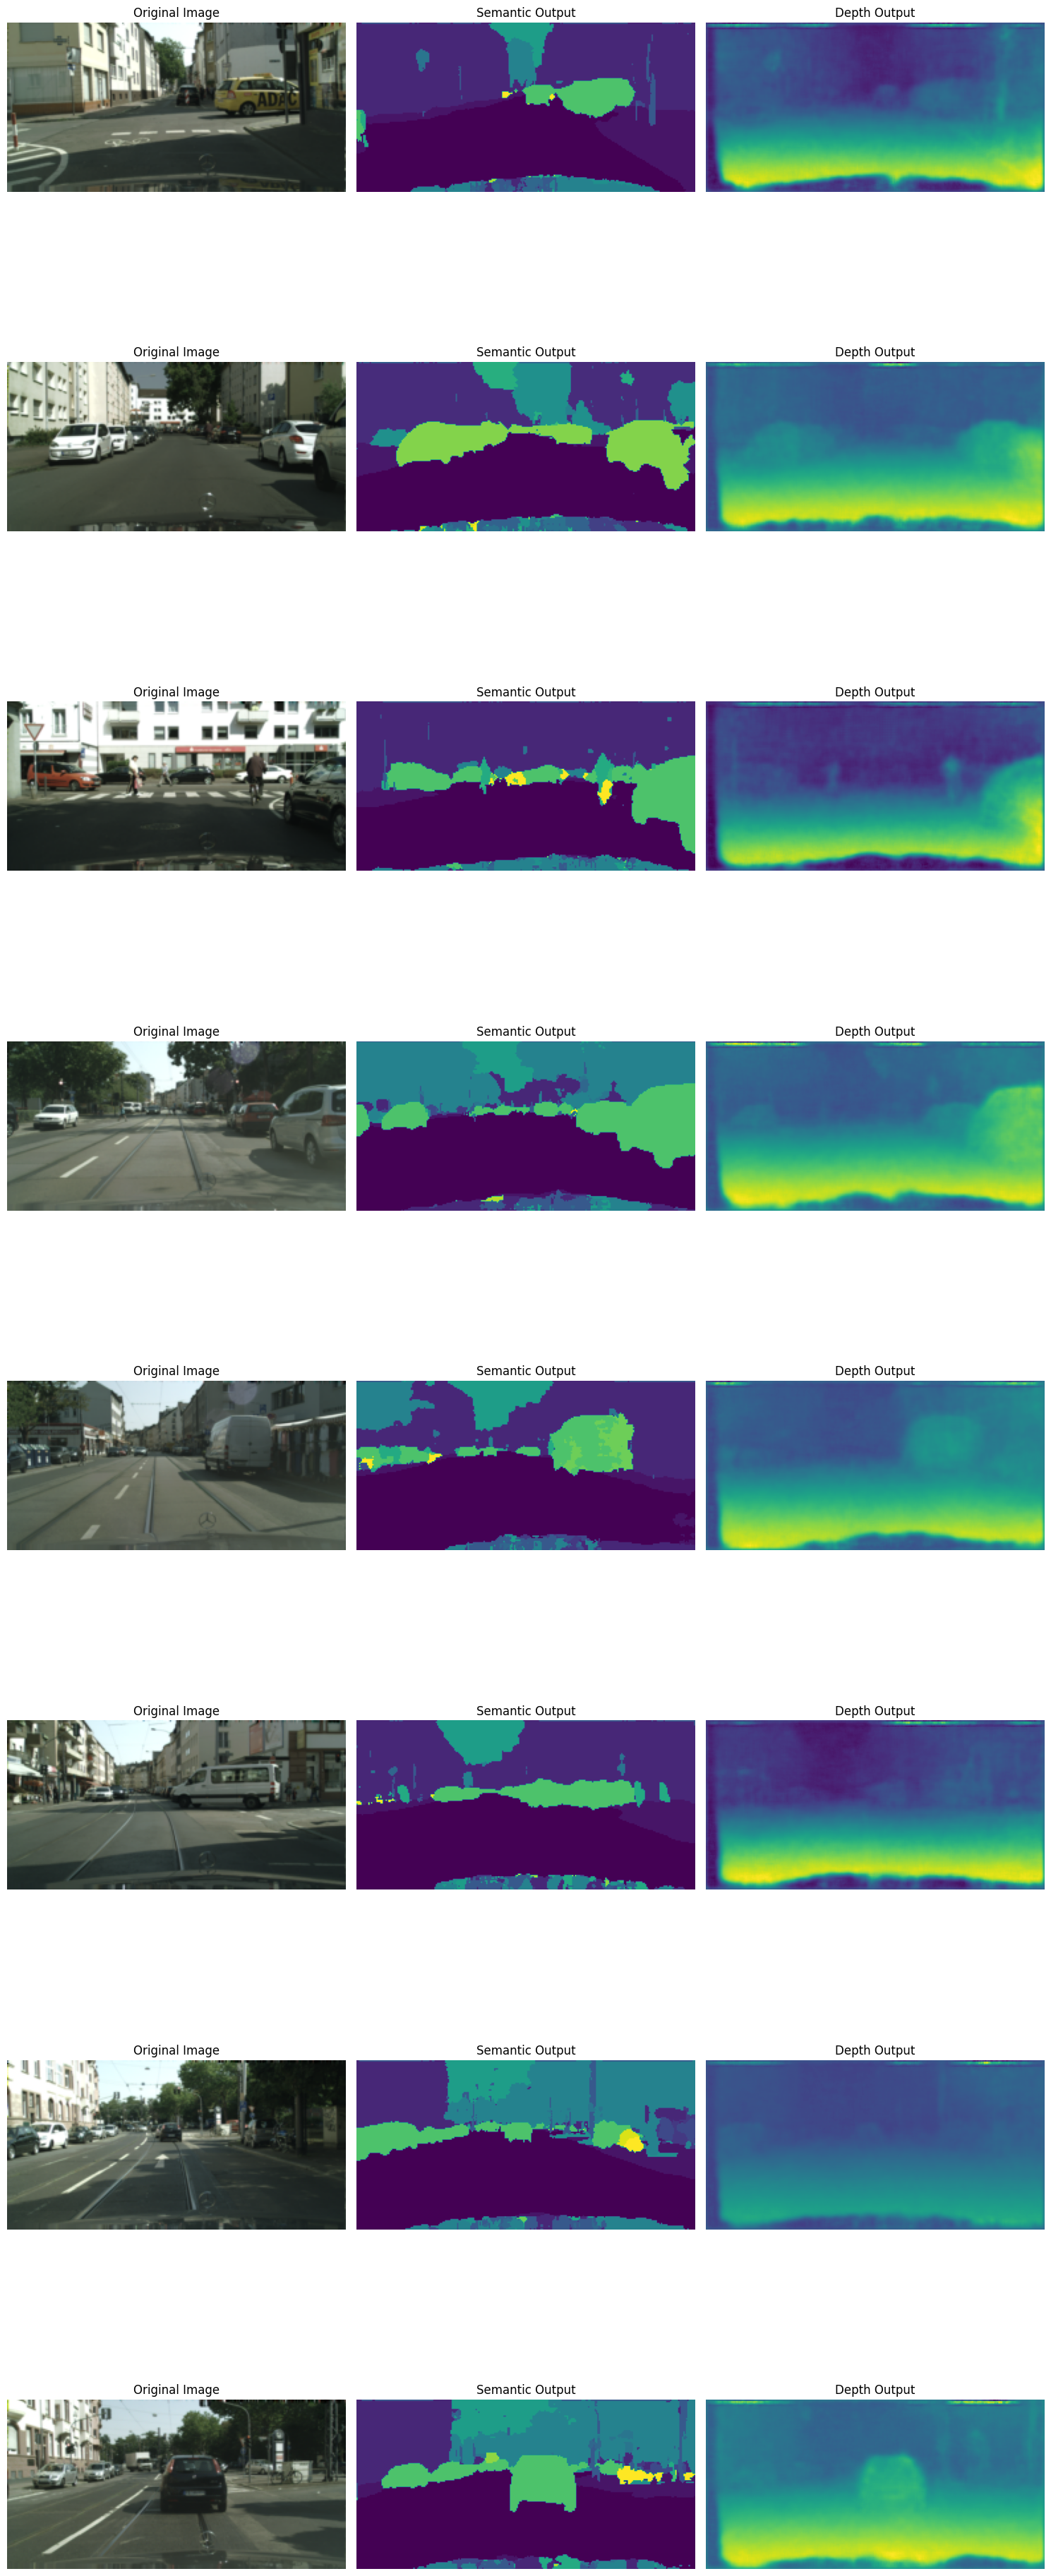

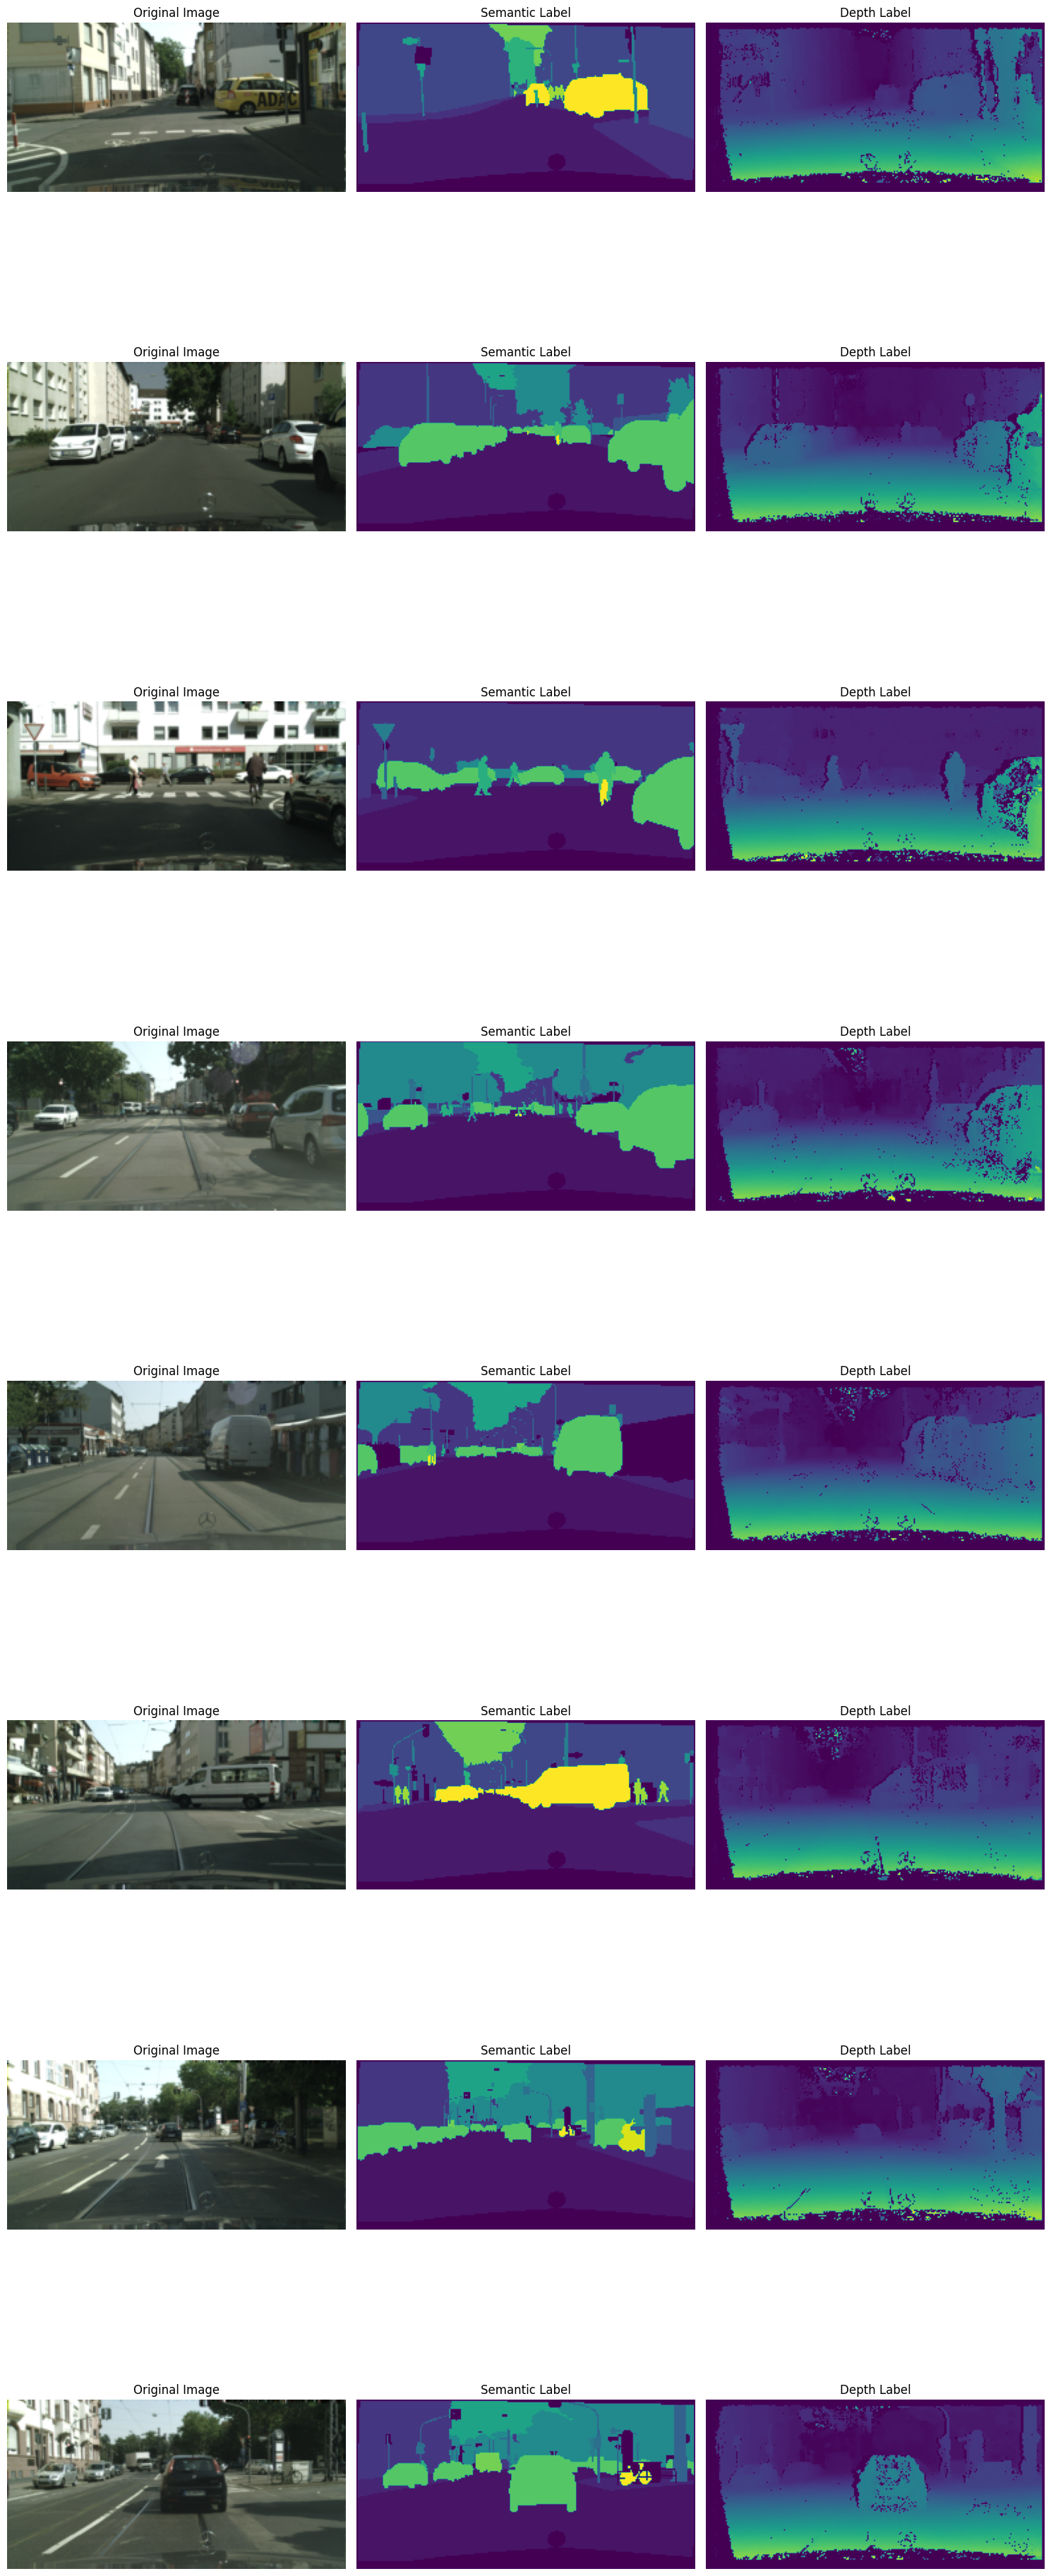

In [81]:
import matplotlib.pyplot as plt

def visualize_results(images, semantic_output, depth_output):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    
    for i in range(num_images):
        axes[i, 0].imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(semantic_output[i].cpu().numpy(), cmap='viridis')
        axes[i, 1].set_title('Semantic Output')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(depth_output[i].cpu().numpy(), cmap='viridis')
        axes[i, 2].set_title('Depth Output')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
def visualize_results1(images, semantic_output, depth_output):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    
    for i in range(num_images):
        axes[i, 0].imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Hiển thị ảnh ngữ nghĩa
        axes[i, 1].imshow(semantic_output[i].cpu().numpy(), cmap='viridis')
        axes[i, 1].set_title('Semantic Label')
        axes[i, 1].axis('off')
        
        # Hiển thị ảnh chiều sâu
        axes[i, 2].imshow(depth_output[i].cpu().numpy(), cmap='viridis')
        axes[i, 2].set_title('Depth Label')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

with torch.no_grad():
    avg_losses = evaluation_epoch(test_loader, model, device)
    for i, batch in enumerate(test_loader):
        images = batch['image'].to(device)
        semantic = batch['semantic'].long().to(device)
        depth = batch['depth'].to(device)
        
        
        output = model(images)
        semantic_output = torch.argmax(output['semantic'], dim=1).squeeze()
        semantic_label = torch.argmax(batch['semantic'], dim=1).squeeze()
#         print(images.shape, semantic_output.shape, output['depth'].squeeze().shape)
#         print(images.shape, semantic.shape, depth.shape)
        # Visualize results
        visualize_results(images, semantic_output, output['depth'].squeeze())
        visualize_results1(images,semantic , depth.squeeze())
        break

In [ ]:
loaded_model = torch.load('/kaggle/working/GLPWithSegFormerModel')

In [ ]:
model = GLPDepthWithSegmentation()
x = torch.rand(4,3,128,256)
y = model(x)
print(y['semantic'].shape, y['depth'].shape)